In [ ]:
# 1. Import 
import os
import datetime
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense,LSTM,Dropout

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

2024-11-13 09:39:13.832797: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# 2. Load data
os.chdir(r"/Users/haris/Desktop/Capstone1(Covid19)")
CSV_path = "/Users/haris/Desktop/Capstone1(Covid19)/Dataset/covid19/cases_malaysia.csv"
MODEL_PATH = os.path.join(os.getcwd(),'model', 'covid19.pkl')

df = pd.read_csv(CSV_path, parse_dates=['date'], index_col=["date"])

df.head()


,cases_new,cases_import,cases_recovered,cases_active,cases_cluster,cases_unvax,cases_pvax,cases_fvax,cases_boost,cases_child,...,cases_60_69,cases_70_79,cases_80,cluster_import,cluster_religious,cluster_community,cluster_highRisk,cluster_education,cluster_detentionCentre,cluster_workplace
date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,4,4,0,4,0,4,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-26,0,0,0,4,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-27,0,0,0,4,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-28,0,0,0,4,0,0,0,0,0,0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-01-29,3,3,0,7,0,3,0,0,0,1,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
# Impute NaN values with the mean of each column
df['cluster_import'] = df['cluster_import'].fillna(0)
df['cluster_religious'] = df['cluster_religious'].fillna(0)
df['cluster_community'] = df['cluster_community'].fillna(0)
df['cluster_highRisk'] = df['cluster_highRisk'].fillna(0)
df['cluster_education'] = df['cluster_education'].fillna(0)
df['cluster_detentionCentre'] = df['cluster_detentionCentre'].fillna(0)
df['cluster_workplace'] = df['cluster_workplace'].fillna(0)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1744 entries, 2020-01-25 to 2024-11-02
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   cases_new                1744 non-null   int64  
 1   cases_import             1744 non-null   int64  
 2   cases_recovered          1744 non-null   int64  
 3   cases_active             1744 non-null   int64  
 4   cases_cluster            1744 non-null   int64  
 5   cases_unvax              1744 non-null   int64  
 6   cases_pvax               1744 non-null   int64  
 7   cases_fvax               1744 non-null   int64  
 8   cases_boost              1744 non-null   int64  
 9   cases_child              1744 non-null   int64  
 10  cases_adolescent         1744 non-null   int64  
 11  cases_adult              1744 non-null   int64  
 12  cases_elderly            1744 non-null   int64  
 13  cases_0_4                1744 non-null   int64  
 14  cases_

In [5]:
print(df.isna().sum())

cases_new                  0
cases_import               0
cases_recovered            0
cases_active               0
cases_cluster              0
cases_unvax                0
cases_pvax                 0
cases_fvax                 0
cases_boost                0
cases_child                0
cases_adolescent           0
cases_adult                0
cases_elderly              0
cases_0_4                  0
cases_5_11                 0
cases_12_17                0
cases_18_29                0
cases_30_39                0
cases_40_49                0
cases_50_59                0
cases_60_69                0
cases_70_79                0
cases_80                   0
cluster_import             0
cluster_religious          0
cluster_community          0
cluster_highRisk           0
cluster_education          0
cluster_detentionCentre    0
cluster_workplace          0
dtype: int64


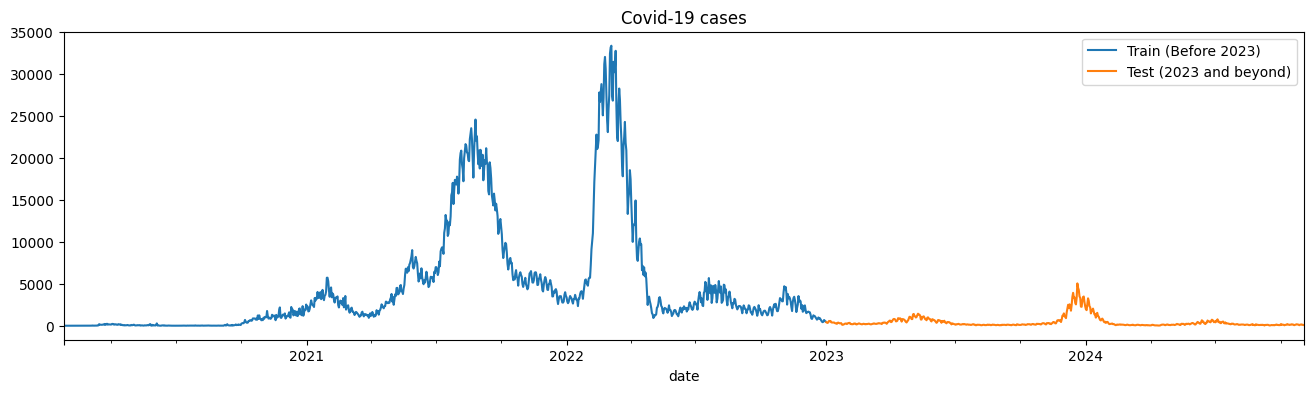

In [6]:
tstart = 2020
tend = 2022

def train_test_plot(df,tstart,tend):
    df.loc[f'{tstart}':f'{tend}','cases_new'].plot(figsize=(16,4),label=f"Train (Before {tend+1})")
    df.loc[f'{tend+1}':, 'cases_new'].plot(figsize=(16,4),label=f"Test ({tend+1} and beyond)")
    plt.legend()
    plt.title('Covid-19 cases')
    plt.show()

train_test_plot(df,tstart,tend)

In [7]:
def train_test_split(df,tstart,tend):
    train = df.loc[f"{tstart}":f"{tend}","cases_new"].values
    test = df.loc[f"{tend+1}":,"cases_new"].values
    return train,test

training_set,test_set = train_test_split(df,tstart,tend)

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
training_set = training_set.reshape(-1,1)
training_set_scaled = sc.fit_transform(training_set)
print(training_set_scaled[:5])

[[1.19738969e-04]
 [0.00000000e+00]
 [0.00000000e+00]
 [0.00000000e+00]
 [8.98042268e-05]]


In [9]:
def split_sequence(sequence,n_steps):
    X,y = list(),list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x,seq_y = sequence[i:end_ix],sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X),np.array(y)

n_steps = 30
features = 1
# split into samples
X_train,y_train = split_sequence(training_set_scaled,n_steps)

In [10]:
print(X_train.shape)

(1042, 30, 1)


In [13]:
# The LSTM Architecture
model_lstm = Sequential()
model_lstm.add(LSTM(units=32,activation='tanh',input_shape=(n_steps,features),return_sequences=True))
model_lstm.add(Dropout(0.2))
model_lstm.add(LSTM(units=64))
model_lstm.add(Dense(units=1))
# Compiling the model
model_lstm.compile(optimizer='adam',loss='mse', metrics=['mae'])

print(model_lstm.summary())


/opt/anaconda3/envs/tensorflow_cpu/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 32)         │         4,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,249 (114.25 KB)

 Trainable params: 29,249 (114.25 KB)

 Non-trainable params: 0 (0.00 B)

None


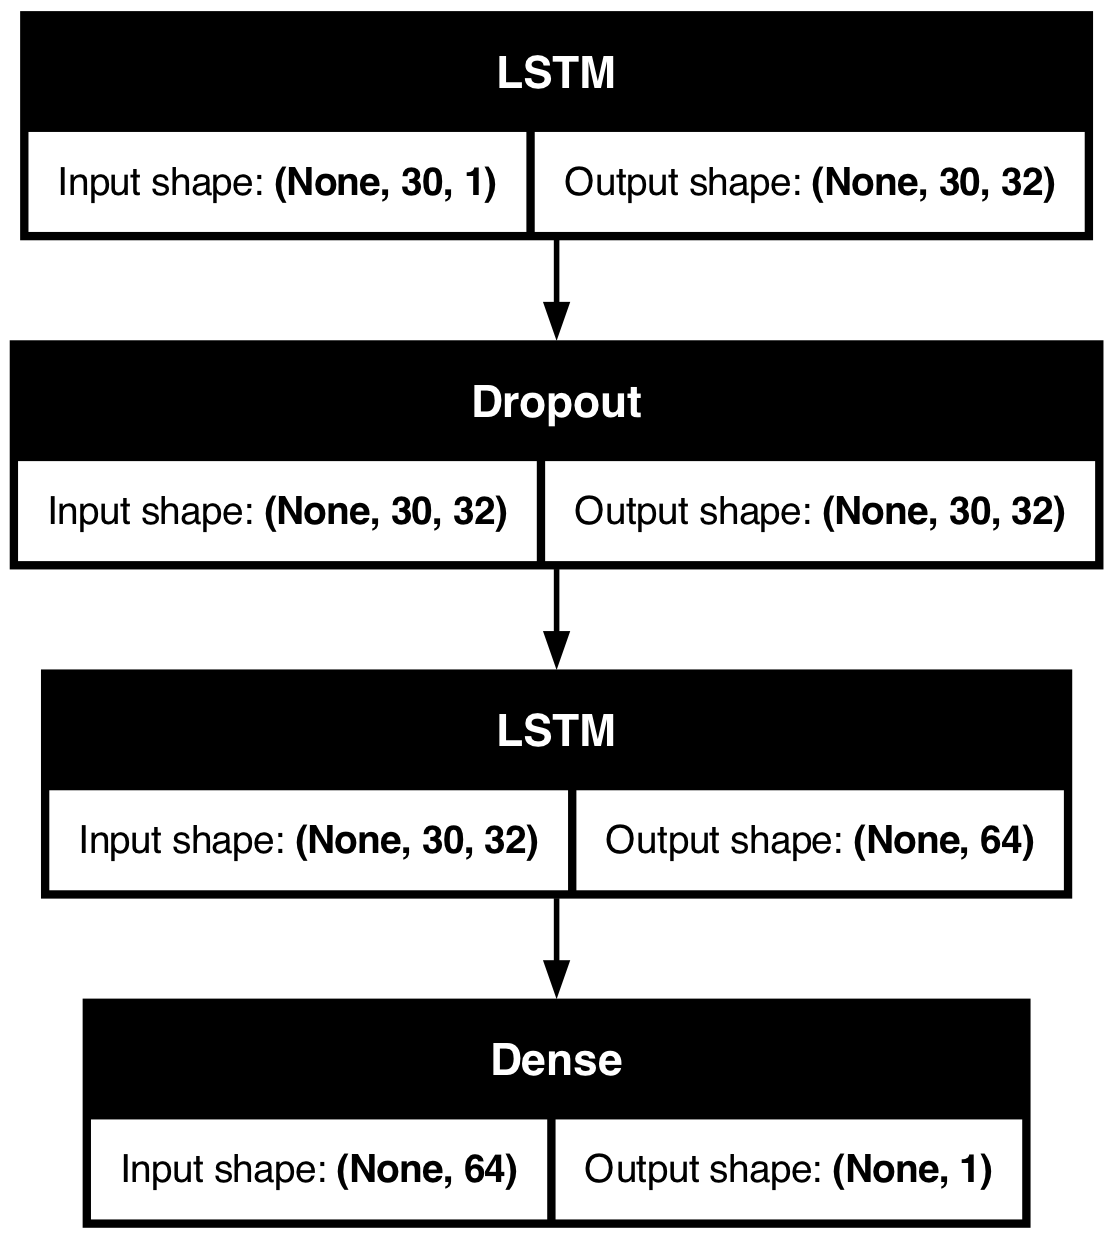

In [12]:
tf.keras.utils.plot_model(model_lstm, to_file='model.png', show_shapes=True)

In [ ]:
# Define tensorboard callback
logpath = "tensorboard/Covid19/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tb = keras.callbacks.TensorBoard(logpath)

In [40]:
model_lstm.fit(X_train, y_train, epochs = 100,batch_size=32, callbacks=[tb])

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 0.0181 - mae: 0.0754
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0027 - mae: 0.0294
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0015 - mae: 0.0224
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0019 - mae: 0.0243
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0015 - mae: 0.0241
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0019 - mae: 0.0248
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0016 - mae: 0.0232
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0017 - mae: 0.0235
Epoch 9/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0017 - mae: 0.0255
Epoch 10/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0020 - mae: 0.0276
Epoch 11/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0017 - mae: 0.0253
Epoch 12/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0013 - mae: 0.0216
Epoch 13/100
33/33 ━━━━━━

In [41]:
# Result

dataset_total = df.loc[:,'cases_new']
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1,1)
# scaling
inputs = sc.transform(inputs)

# Split into samples
X_test,y_test = split_sequence(inputs,n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],features)
# predictions
predicted_cases_new = model_lstm.predict(X_test)
# inverse transform the values - undo the normalization of stock prices (undo any sklearn's transform)
predicted_cases_new = sc.inverse_transform(predicted_cases_new)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


In [42]:
def plot_predictions(test,predicted):
    plt.plot(test,color='gray',label='Real')
    plt.plot(predicted,color='red',label='Predicted')
    plt.title('Covid19 Prediction')
    plt.xlabel('Time')
    plt.ylabel('Cases new ')
    plt.legend()
    plt.show()

evaluation = model_lstm.evaluate(X_test,y_test)
# print(evaluation)

mae = evaluation[1]
print(f"mae score: {mae}")

mape = mae/sum(abs(y_test)) *100
print(f"mape score: {mape}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.7673e-05 - mae: 0.0031 
mae score: 0.003175890538841486
mape score: [0.03626816]


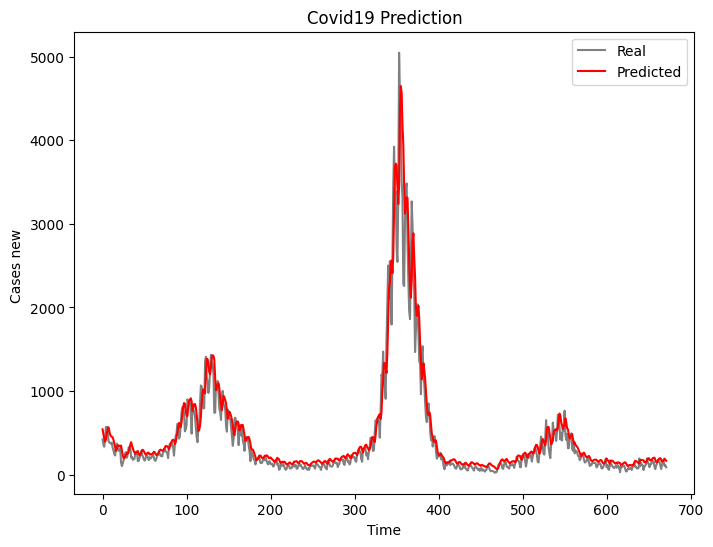

In [43]:
plot_predictions(test_set,predicted_cases_new)

In [52]:
import pickle

best_model = model_lstm

with open(MODEL_PATH, 'wb') as file:
    pickle.dump(best_model,file)